In [6]:
import os
import pandas as pd
import numpy as np
import io
import json
import pickle
#import requests
#import joblib
import math
#from sklearn.model_selection import train_test_split
#from sklearn.pipeline import make_pipeline, Pipeline
#from sklearn.preprocessing import OneHotEncoder, StandardScaler, RobustScaler
#from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, precision_recall_curve
#from sklearn.compose import ColumnTransformer
#from sklearn.impute import SimpleImputer
#from sklearn.ensemble import RandomForestClassifier
#from lightgbm import LGBMClassifier
#from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt
import seaborn as sns
#from scipy.stats import ks_2samp
import warnings
warnings.filterwarnings("ignore")

### Open the data

In [7]:
# open data and set 'Date' column to datetime format
train = pd.read_csv('data/train.csv',parse_dates=['Date'])

# set 'observation_id' as index of dataset
#train = train.set_index('observation_id')
train.head()

,observation_id,Type,Date,Part of a policing operation,Latitude,Longitude,Gender,Age range,Self-defined ethnicity,Officer-defined ethnicity,Legislation,Object of search,Outcome,Outcome linked to object of search,Removal of more than just outer clothing,station
0,2e4d0094-c30b-471b-a211-72a9790feca2,Person search,2020-12-01T01:10:00+00:00,NaN,50.798824,-1.089471,Male,25-34,Other ethnic group - Not stated,White,Police and Criminal Evidence Act 1984 (section 1),Article for use in theft,Community resolution,False,False,hampshire
1,4779fbe8-6e05-4534-85fd-db32952ee309,Person search,2020-12-01T02:00:00+00:00,NaN,50.785099,-1.091540,Male,over 34,White - Any other White background,Other,Misuse of Drugs Act 1971 (section 23),Controlled drugs,A no further action disposal,False,False,hampshire
2,cb5c685d-acac-42e2-914d-75e6ff73b0a8,Person search,2020-12-01T09:15:00+00:00,NaN,50.952006,-1.403341,Male,over 34,White - English/Welsh/Scottish/Northern Irish/...,White,Misuse of Drugs Act 1971 (section 23),Controlled drugs,A no further action disposal,False,True,hampshire
3,f486e116-5b1e-45db-9931-a7f070c5c478,Person search,2020-12-01T10:20:00+00:00,NaN,50.806383,-1.079844,Male,10-17,Other ethnic group - Not stated,White,Police and Criminal Evidence Act 1984 (section 1),Stolen goods,A no further action disposal,False,False,hampshire
4,78f4020e-12cc-4889-bf1a-2f2c29b2f662,Person search,2020-12-01T10:24:00+00:00,NaN,50.806670,-1.081982,Male,10-17,Other ethnic group - Not stated,Asian,Police and Criminal Evidence Act 1984 (section 1),Offensive weapons,A no further action disposal,False,False,hampshire


### Explore the dataset

In [8]:
# check dtypes of columns
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 856610 entries, 0 to 856609
Data columns (total 16 columns):
 #   Column                                    Non-Null Count   Dtype  
---  ------                                    --------------   -----  
 0   observation_id                            856610 non-null  object 
 1   Type                                      856610 non-null  object 
 2   Date                                      856610 non-null  object 
 3   Part of a policing operation              646620 non-null  object 
 4   Latitude                                  700308 non-null  float64
 5   Longitude                                 700308 non-null  float64
 6   Gender                                    856610 non-null  object 
 7   Age range                                 856610 non-null  object 
 8   Self-defined ethnicity                    841427 non-null  object 
 9   Officer-defined ethnicity                 856610 non-null  object 
 10  Legislation         

In [5]:
# check duplicate entries
train.duplicated().sum()

0

In [9]:
# check missing values
train.isna().sum()

observation_id                                   0
Type                                             0
Date                                             0
Part of a policing operation                209990
Latitude                                    156302
Longitude                                   156302
Gender                                           0
Age range                                        0
Self-defined ethnicity                       15183
Officer-defined ethnicity                        0
Legislation                                  39747
Object of search                                 0
Outcome                                          0
Outcome linked to object of search          601927
Removal of more than just outer clothing    516513
station                                          0
dtype: int64

In [7]:
# Observation_id can be used as index as it contains only unique values
train['observation_id'].nunique()

856610

#### TYPE

In [8]:
# check the types of search operations
train['Type'].value_counts(dropna=False)

Person search                637921
Person and Vehicle search    217570
Vehicle search                 1119
Name: Type, dtype: int64

In [9]:
# check the types of search operations (normalized)
train['Type'].value_counts(dropna=False,normalize=True)

Person search                0.744704
Person and Vehicle search    0.253990
Vehicle search               0.001306
Name: Type, dtype: float64

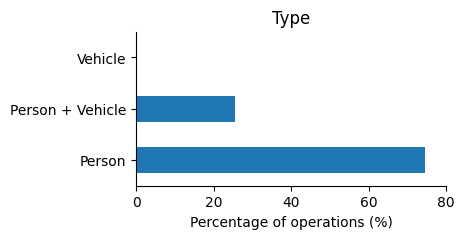

In [10]:
# Plot horizontal bar-plot of "Type" feature
plt.figure(figsize=(4,2))
plt.title('Type')
plt.xlabel('Percentage of operations (%)')
train['Type'].value_counts(normalize=True).plot(kind='barh')
plt.xticks([0,0.2,0.4,0.6,0.8],['0','20','40','60','80'])
plt.yticks([0,1,2],['Person','Person + Vehicle', 'Vehicle'])
sns.despine()

#### DATE

In [11]:
# check range of dates in the dataset
print (train['Date'].min())
print (train['Date'].max())

2020-02-01 00:00:00+00:00
2021-12-31 23:59:00+00:00


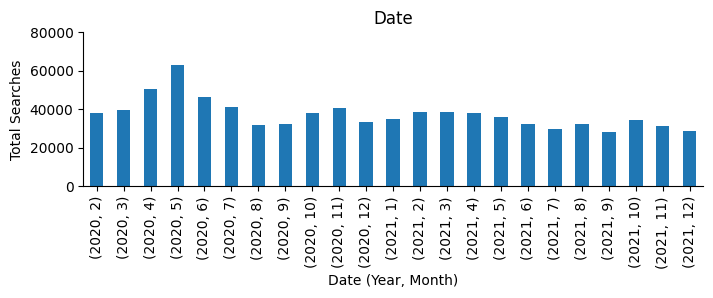

In [12]:
# Plot histogram of date feature
plt.figure(figsize=(8,2))
plt.title('Date')
train['Date'].groupby([train["Date"].dt.year, train["Date"].dt.month]).count().plot(kind="bar",rot=90)
plt.xlabel('Date (Year, Month)')
plt.ylabel('Total Searches')
plt.ylim(0,80000)
sns.despine()

In [13]:
# Show the total number of search operations grouped by year,month across time
train['Date'].groupby([train["Date"].dt.year, train["Date"].dt.month]).count()

Date  Date
2020  2       37810
      3       39446
      4       50484
      5       62763
      6       46382
      7       40921
      8       31974
      9       32223
      10      38290
      11      40448
      12      33337
2021  1       35024
      2       38809
      3       38502
      4       37987
      5       35743
      6       32083
      7       29767
      8       32300
      9       28396
      10      34216
      11      31177
      12      28528
Name: Date, dtype: int64

<AxesSubplot:xlabel='Date,Date'>

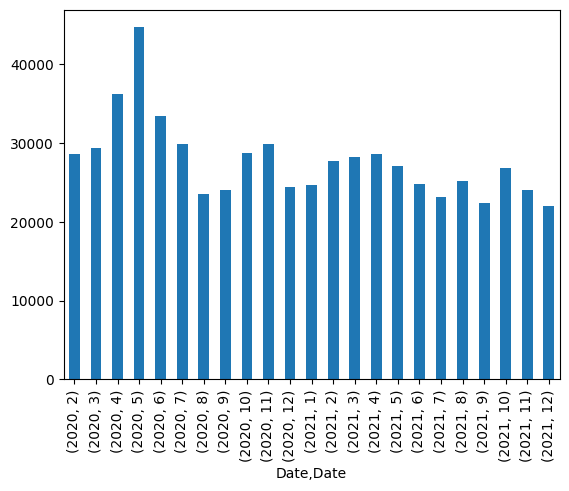

In [14]:
# Split operations by type
person_only = train[train['Type']=='Person search']
vehicle_only = train[train['Type']=='Vehicle search']
person_and_vehicle = train[train['Type']=='Person and Vehicle search']

# Distribuition of stop and search operations across time in PERSON SEARCHES ONLY
person_only['Date'].groupby([person_only["Date"].dt.year, person_only["Date"].dt.month]).count().plot(kind="bar")

<AxesSubplot:xlabel='Date,Date'>

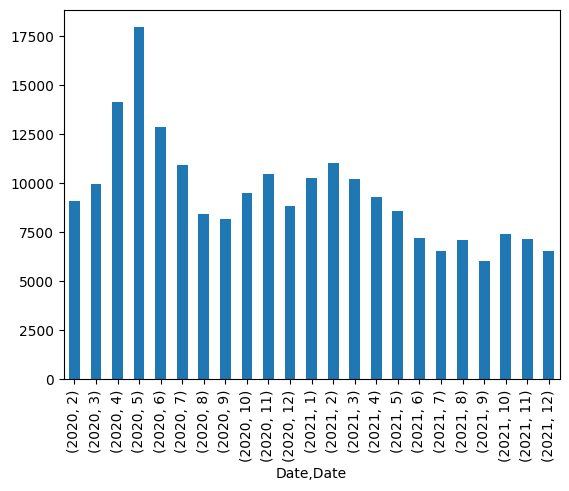

In [15]:
# Distribuition of stop and search operations across time in PERSON AND VEHICLE SEARCHES
person_and_vehicle['Date'].groupby([person_and_vehicle["Date"].dt.year, person_and_vehicle["Date"].dt.month]).count().plot(kind="bar")

<AxesSubplot:xlabel='Date,Date'>

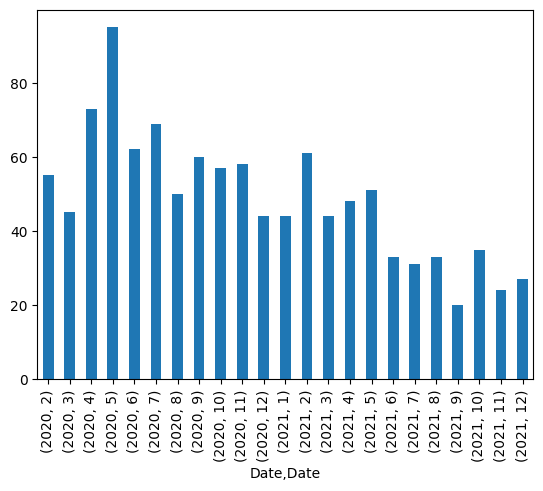

In [16]:
# Distribuition of stop and search operations across time in VEHICLE SEARCHES ONLY
vehicle_only['Date'].groupby([vehicle_only["Date"].dt.year, vehicle_only["Date"].dt.month]).count().plot(kind="bar")

#### PART OF A POLICING OPERATION

In [17]:
# check whether the search opperation was part of a policing operation or not 
train['Part of a policing operation'].value_counts(dropna=False)

False    628148
NaN      209990
True      18472
Name: Part of a policing operation, dtype: int64

In [18]:
# check whether the search opperation was part of a policing operation or not (normalized)
train['Part of a policing operation'].value_counts(dropna=False,normalize=True)

False    0.733295
NaN      0.245141
True     0.021564
Name: Part of a policing operation, dtype: float64

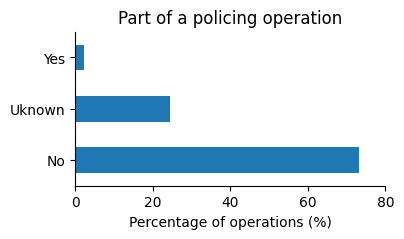

In [19]:
# Plot a bar-plot of "Part of a Policing Operation" feature
plt.figure(figsize=(4,2))
plt.title('Part of a policing operation')
plt.xlabel('Percentage of operations (%)')
train['Part of a policing operation'].value_counts(normalize=True,dropna=False).plot(kind='barh')
plt.xticks([0,0.2,0.4,0.6,0.8],['0','20','40','60','80'])
plt.yticks([0,1,2],['No','Uknown', 'Yes'])
sns.despine()

#### GENDER

In [20]:
# check the gender of the target of the search opperation
train['Gender'].value_counts(dropna=False)

Male      774566
Female     81139
Other        905
Name: Gender, dtype: int64

In [21]:
# check the gender of the target of the search opperation (normalized)
train['Gender'].value_counts(dropna=False,normalize=True)

Male      0.904222
Female    0.094721
Other     0.001056
Name: Gender, dtype: float64

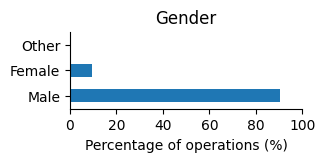

In [22]:
# Plot a bar-plot of "Part of a Policing Operation" feature
plt.figure(figsize=(3,1))
plt.title('Gender')
plt.xlabel('Percentage of operations (%)')
train['Gender'].value_counts(normalize=True,dropna=False).plot(kind='barh',rot=0)
plt.xticks([0,0.2,0.4,0.6,0.8,1],['0','20','40','60','80','100'])
sns.despine()

#### AGE

In [23]:
# check the age of the target of the search opperation
train['Age range'].value_counts(dropna=False)

18-24       307185
25-34       215998
over 34     184905
10-17       148083
under 10       439
Name: Age range, dtype: int64

In [24]:
# check the age of the target of the search opperation (normalized)
train['Age range'].value_counts(dropna=False,normalize=True)

18-24       0.358605
25-34       0.252154
over 34     0.215857
10-17       0.172871
under 10    0.000512
Name: Age range, dtype: float64

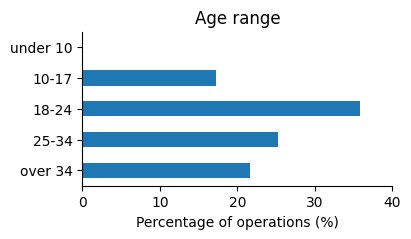

In [25]:
# plot histogram with distribuition of ages in dataset

# list with order of ages
order = ["over 34","25-34","18-24","10-17","under 10"]

plt.figure(figsize=(4,2))
plt.title('Age range')
plt.xlabel('Percentage of operations (%)')
train['Age range'].value_counts(normalize=True,dropna=False).reindex(order).plot(kind='barh')
plt.xticks([0,0.1,0.2,0.3,0.4],['0','10','20','30','40'])
sns.despine()

#### SELF-DEFINED ETHNICITY

In [26]:
# check the self-defined ethinicity of the target of the search opperation
train['Self-defined ethnicity'].value_counts(dropna=False)

White - English/Welsh/Scottish/Northern Irish/British                                   353095
Other ethnic group - Not stated                                                         136650
White - Any other White background                                                       74405
Black/African/Caribbean/Black British - Any other Black/African/Caribbean background     62216
Black/African/Caribbean/Black British - African                                          43750
Asian/Asian British - Any other Asian background                                         40676
Black/African/Caribbean/Black British - Caribbean                                        28864
Asian/Asian British - Pakistani                                                          23903
Asian/Asian British - Bangladeshi                                                        16808
Other ethnic group - Any other ethnic group                                              15203
NaN                                               

In [27]:
# check the self-defined ethinicity of the target of the search opperation
train['Self-defined ethnicity'].value_counts(dropna=False,normalize=True)

White - English/Welsh/Scottish/Northern Irish/British                                   0.412200
Other ethnic group - Not stated                                                         0.159524
White - Any other White background                                                      0.086860
Black/African/Caribbean/Black British - Any other Black/African/Caribbean background    0.072630
Black/African/Caribbean/Black British - African                                         0.051073
Asian/Asian British - Any other Asian background                                        0.047485
Black/African/Caribbean/Black British - Caribbean                                       0.033696
Asian/Asian British - Pakistani                                                         0.027904
Asian/Asian British - Bangladeshi                                                       0.019622
Other ethnic group - Any other ethnic group                                             0.017748
NaN                           

In [28]:
# total number of self-defined ethnicities
train['Self-defined ethnicity'].nunique()

19

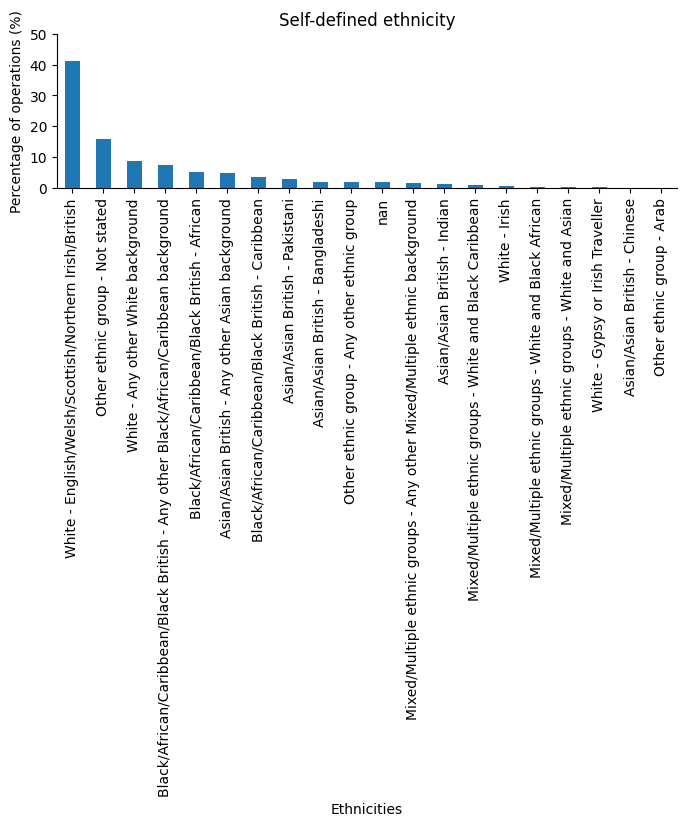

In [29]:
# plot a histogram of all self-defined ethnicities
plt.figure(figsize=(8,2))
plt.title('Self-defined ethnicity')
train['Self-defined ethnicity'].value_counts(normalize=True,dropna=False).plot(kind='bar')
plt.xlabel('Ethnicities')
plt.ylabel('Percentage of operations (%)')
plt.yticks([0,0.1,0.2,0.3,0.4,0.5],["0","10","20","30","40","50"])
sns.despine()

In [30]:
# create a dictionary with a mapping of the self-defined ethnicity to it's main categories
mapping = {'White': ['White - Any other White background',
                     'White - English/Welsh/Scottish/Northern Irish/British',
                     'White - Irish',
                     'White - Gypsy or Irish Traveller'],
           'Black': ['Black/African/Caribbean/Black British - Any other Black/African/Caribbean background',
                     'Black/African/Caribbean/Black British - Caribbean',
                     'Black/African/Caribbean/Black British - African'],
           'Asian': ['Asian/Asian British - Any other Asian background',
                     'Asian/Asian British - Indian',
                     'Asian/Asian British - Bangladeshi',
                     'Asian/Asian British - Chinese',
                     'Asian/Asian British - Pakistani'],
           'Other': ['Other ethnic group - Not stated',
                     'Other ethnic group - Any other ethnic group',
                     'Other ethnic group - Arab'],
           'Mixed': ['Mixed/Multiple ethnic groups - White and Black African',
                     'Mixed/Multiple ethnic groups - White and Asian',
                     'Mixed/Multiple ethnic groups - Any other Mixed/Multiple ethnic background',
                     'Mixed/Multiple ethnic groups - White and Black Caribbean']}

In [31]:
# create a function to apply the the mapping to a given column
def map_ethnicity(value):
    for key, values in mapping.items():
        if value in values:
            return key
    return 'Unknown'

In [32]:
# apply the function to the "self-defined ethnicity" column
train['Self-defined ethnicity_broad'] = train['Self-defined ethnicity'].apply(map_ethnicity)

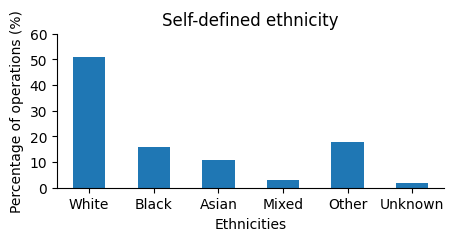

In [33]:
# plot
order = ['White','Black','Asian','Mixed', 'Other', 'Unknown']

plt.figure(figsize=(5,2))
plt.title('Self-defined ethnicity')
train['Self-defined ethnicity_broad'].value_counts(normalize=True,dropna=False).reindex(order).plot(kind='bar',rot=0)
plt.xlabel('Ethnicities')
plt.ylabel('Percentage of operations (%)')
plt.yticks([0,0.1,0.2,0.3,0.4,0.5,0.6],["0","10","20","30","40","50","60"])
sns.despine()

#### OFFICER-DEFINED ETHNICITY

In [34]:
# check the officer-defined ethinicity of the target of the search opperation
train['Officer-defined ethnicity'].value_counts(dropna=False)

White    507627
Black    197137
Asian    119785
Other     29035
Mixed      3026
Name: Officer-defined ethnicity, dtype: int64

In [35]:
# check the officer-defined ethinicity of the target of the search opperation (normalized)
train['Officer-defined ethnicity'].value_counts(dropna=False,normalize=True)

White    0.592600
Black    0.230136
Asian    0.139836
Other    0.033895
Mixed    0.003533
Name: Officer-defined ethnicity, dtype: float64

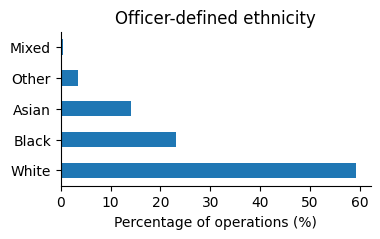

In [36]:
# plot histogram with distribuition of officer-defined ethnicities in dataset
plt.figure(figsize=(4,2))
plt.title('Officer-defined ethnicity')
plt.xlabel('Percentage of operations (%)')
train['Officer-defined ethnicity'].value_counts(normalize=True,dropna=False).plot(kind='barh')
plt.xticks([0,0.1,0.2,0.3,0.4,0.5,0.6],['0','10','20','30','40','50','60'])
sns.despine()

In [37]:
# order of ethnicities in x-axis
order = ['White','Black','Asian','Mixed', 'Other']

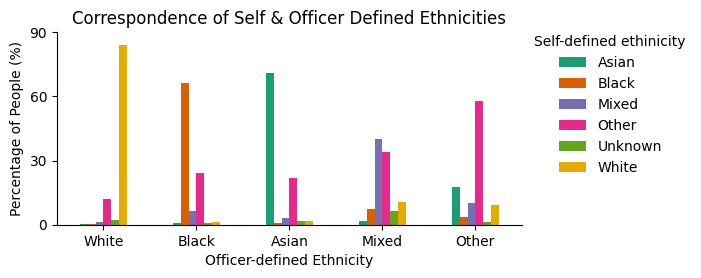

In [38]:
# Convert officer-defined ethnicity column to a categorical data type with specified order
train['Officer-defined ethnicity'] = train['Officer-defined ethnicity'].astype(pd.CategoricalDtype(categories=order, ordered=True))

# Count occurrences of self-defined ethnicity values within each officer-defined ethnicity category
counts = train.groupby('Officer-defined ethnicity')['Self-defined ethnicity_broad'].value_counts(normalize=True)*100

# Convert counts to a dataframe
counts_df = counts.unstack()

# colors
palette_tab10 = sns.color_palette("Dark2", 10)

# Create histogram
counts_df.plot(kind='bar',figsize=(6, 2.5), rot=0,color=palette_tab10)
plt.title('Correspondence of Self & Officer Defined Ethnicities')
plt.xlabel('Officer-defined Ethnicity')
plt.ylabel('Percentage of People (%)')
plt.legend(title='Self-defined ethinicity', frameon=False, ncol=1, bbox_to_anchor=(1, 1.05))
plt.yticks([0,30,60,90])
sns.despine()
plt.show()

#### Legistlation

In [39]:
# check the legislation under which the search opperation was conducted
train['Legislation'].value_counts(dropna=False)

Misuse of Drugs Act 1971 (section 23)                      546936
Police and Criminal Evidence Act 1984 (section 1)          254859
NaN                                                         39747
Criminal Justice and Public Order Act 1994 (section 60)      8711
Firearms Act 1968 (section 47)                               4610
Criminal Justice Act 1988 (section 139B)                      549
Psychoactive Substances Act 2016 (s36(2))                     547
Poaching Prevention Act 1862 (section 2)                      408
Police and Criminal Evidence Act 1984 (section 6)              92
Wildlife and Countryside Act 1981 (section 19)                 39
Environmental Protection Act 1990 (section 34B )               25
Deer Act 1991 (section 12)                                     17
Aviation Security Act 1982 (section 27(1))                     17
Customs and Excise Management Act 1979 (section 163)           16
Hunting Act 2004 (section 8)                                   12
Crossbows 

In [40]:
# check the legislation under which the search opperation was conducted (normalized)
train['Legislation'].value_counts(dropna=False,normalize=True)*100

Misuse of Drugs Act 1971 (section 23)                      63.848893
Police and Criminal Evidence Act 1984 (section 1)          29.752046
NaN                                                         4.640035
Criminal Justice and Public Order Act 1994 (section 60)     1.016916
Firearms Act 1968 (section 47)                              0.538168
Criminal Justice Act 1988 (section 139B)                    0.064090
Psychoactive Substances Act 2016 (s36(2))                   0.063856
Poaching Prevention Act 1862 (section 2)                    0.047630
Police and Criminal Evidence Act 1984 (section 6)           0.010740
Wildlife and Countryside Act 1981 (section 19)              0.004553
Environmental Protection Act 1990 (section 34B )            0.002918
Deer Act 1991 (section 12)                                  0.001985
Aviation Security Act 1982 (section 27(1))                  0.001985
Customs and Excise Management Act 1979 (section 163)        0.001868
Hunting Act 2004 (section 8)      

In [41]:
train['Legislation'].nunique()

19

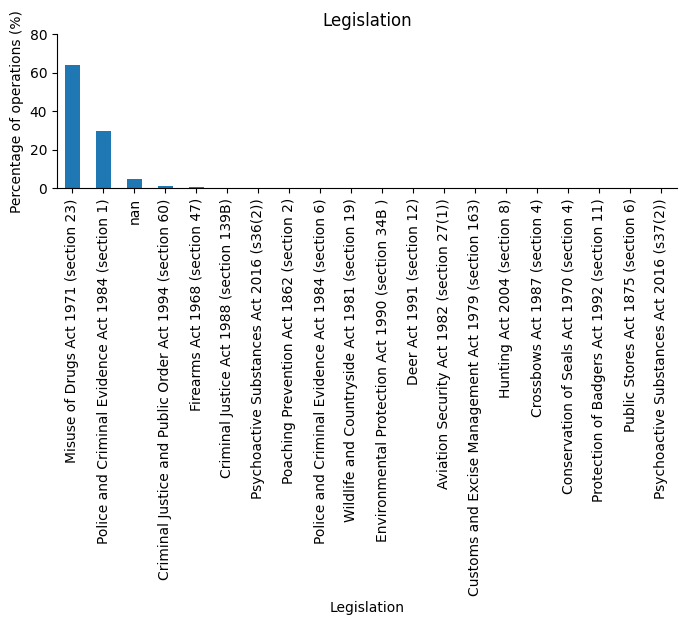

In [42]:
# plot a histogram of all legislations
plt.figure(figsize=(8,2))
plt.title('Legislation')
train['Legislation'].value_counts(normalize=True,dropna=False).plot(kind='bar')
plt.xlabel('Legislation')
plt.ylabel('Percentage of operations (%)')
plt.yticks([0,0.2,0.4,0.6,0.8],["0","20","40","60","80"])
sns.despine()

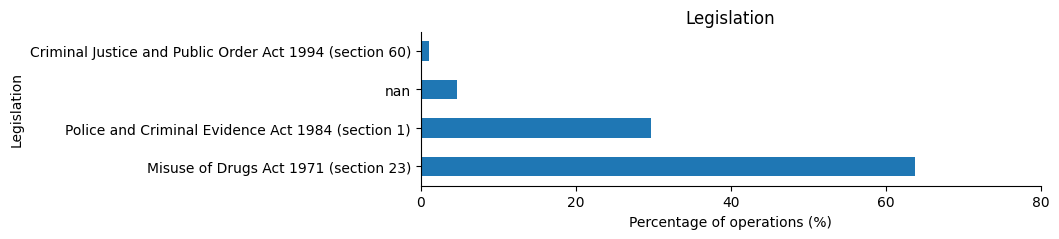

In [43]:
# plot a histogram of all legislations
plt.figure(figsize=(8,2))
plt.title('Legislation')
train['Legislation'].value_counts(normalize=True,dropna=False).plot(kind='barh')
plt.ylabel('Legislation')
plt.xlabel('Percentage of operations (%)')
plt.xticks([0,0.2,0.4,0.6,0.8],["0","20","40","60","80"])
plt.ylim(-0.5,3.5)
sns.despine()

#### OBJECT OF SEARCH

In [44]:
# check the "reason"/object of the search opperation was conducted
train['Object of search'].value_counts(dropna=False)

Controlled drugs                                  558100
Offensive weapons                                 112652
Stolen goods                                       75698
Article for use in theft                           38706
Evidence of offences under the Act                 23080
Articles for use in criminal damage                16696
Anything to threaten or harm anyone                15535
Firearms                                            5420
Fireworks                                           5072
Psychoactive substances                             4805
Game or poaching equipment                           321
Detailed object of search unavailable                309
Goods on which duty has not been paid etc.            97
Crossbows                                             54
Evidence of wildlife offences                         46
Evidence of hunting any wild mammal with a dog        12
Seals or hunting equipment                             7
Name: Object of search, dtype: 

In [45]:
# check the "reason"/object of the search opperation was conducted (normalized)
train['Object of search'].value_counts(dropna=False, normalize=True) * 100

Controlled drugs                                  65.152170
Offensive weapons                                 13.150909
Stolen goods                                       8.836927
Article for use in theft                           4.518509
Evidence of offences under the Act                 2.694342
Articles for use in criminal damage                1.949078
Anything to threaten or harm anyone                1.813544
Firearms                                           0.632727
Fireworks                                          0.592101
Psychoactive substances                            0.560932
Game or poaching equipment                         0.037473
Detailed object of search unavailable              0.036072
Goods on which duty has not been paid etc.         0.011324
Crossbows                                          0.006304
Evidence of wildlife offences                      0.005370
Evidence of hunting any wild mammal with a dog     0.001401
Seals or hunting equipment              

In [46]:
train['Object of search'].nunique()

17

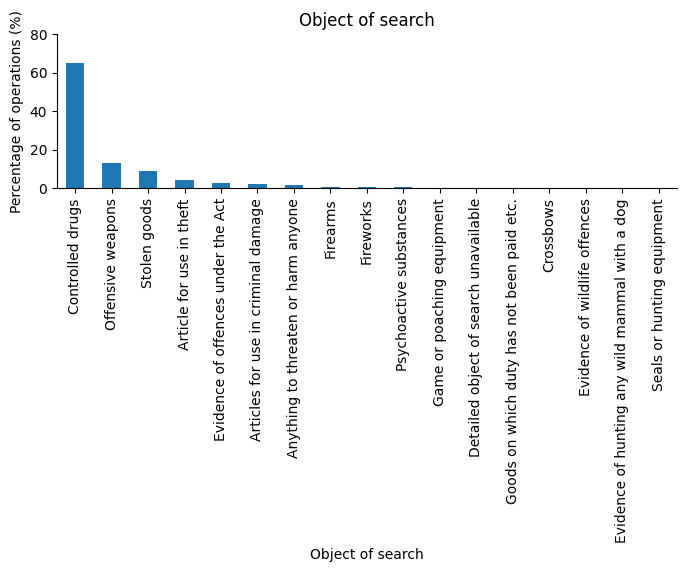

In [45]:
# plot a histogram of all "object of search" category
plt.figure(figsize=(8,2))
plt.title('Object of search')
train['Object of search'].value_counts(normalize=True,dropna=False).plot(kind='bar')
plt.xlabel('Object of search')
plt.ylabel('Percentage of operations (%)')
plt.yticks([0,0.2,0.4,0.6,0.8],["0","20","40","60","80"])
sns.despine()

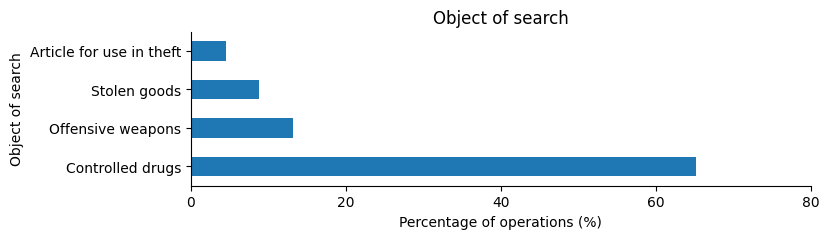

In [116]:
# plot a histogram of all "object of search" category
plt.figure(figsize=(8,2))
plt.title('Object of search')
train['Object of search'].value_counts(normalize=True,dropna=False).plot(kind='barh')
plt.ylabel('Object of search')
plt.xlabel('Percentage of operations (%)')
plt.xticks([0,0.2,0.4,0.6,0.8],["0","20","40","60","80"])
plt.ylim(-0.5,3.5)
sns.despine()

#### OUTCOME

In [46]:
# check the outcome of the search opperation
train['Outcome'].value_counts(dropna=False)

A no further action disposal       627474
Arrest                             111748
Community resolution                68280
Penalty Notice for Disorder         17319
Summons / charged by post           16834
Khat or Cannabis warning            11696
Caution (simple or conditional)      3259
Name: Outcome, dtype: int64

In [47]:
# check the outcome of the search opperation (normalized)
train['Outcome'].value_counts(dropna=False,normalize=True) * 100

A no further action disposal       73.250838
Arrest                             13.045377
Community resolution                7.970955
Penalty Notice for Disorder         2.021807
Summons / charged by post           1.965188
Khat or Cannabis warning            1.365382
Caution (simple or conditional)     0.380453
Name: Outcome, dtype: float64

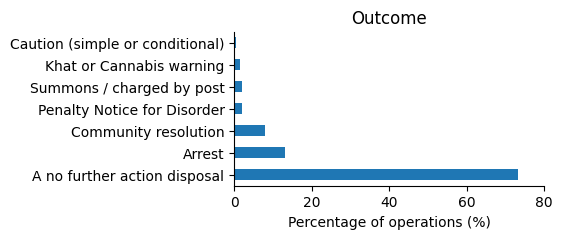

In [48]:
# plot a histogram with a distribuition of all possible Outcomes
plt.figure(figsize=(4,2))
plt.title('Outcome')
plt.xlabel('Percentage of operations (%)')
train['Outcome'].value_counts(normalize=True,dropna=False).plot(kind='barh')
plt.xticks([0,0.2,0.4,0.6,0.8],['0','20','40','60','80'])
sns.despine()

#### OUTCOME LINKED TO OBJECT OF SEARCH

In [49]:
# check whether the outcome of the search was linked to the reason for the search
train['Outcome linked to object of search'].value_counts(dropna=False)

NaN      601927
False    139123
True     115560
Name: Outcome linked to object of search, dtype: int64

In [50]:
# check whether the outcome of the search was linked to the reason for the search (normalized)
train['Outcome linked to object of search'].value_counts(dropna=False,normalize=True) * 100

NaN      70.268500
False    16.241113
True     13.490387
Name: Outcome linked to object of search, dtype: float64

In [51]:
# According to clarifications email, NaNs should be assumed to be False
train['Outcome linked to object of search'].fillna(False).value_counts(dropna=False,normalize=True) * 100

False    86.509613
True     13.490387
Name: Outcome linked to object of search, dtype: float64

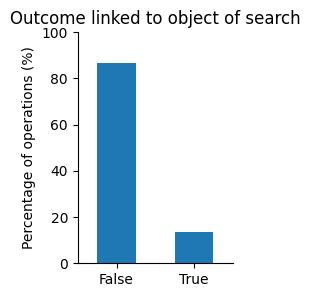

In [52]:
plt.figure(figsize=(2,3))
plt.title('Outcome linked to object of search')
plt.ylabel('Percentage of operations (%)')
train['Outcome linked to object of search'].fillna(False).value_counts(normalize=True,dropna=False).plot(kind='bar',rot=0)
plt.yticks([0,0.2,0.4,0.6,0.8,1],['0','20','40','60','80','100'])
sns.despine()

#### REMOVAL OF MORE THAN JUST OUTER CLOTHING

In [53]:
# Check whether it was required to remove more than outer clothing in search opperation
train['Removal of more than just outer clothing'].value_counts(dropna=False)

NaN      516513
False    327499
True      12598
Name: Removal of more than just outer clothing, dtype: int64

In [54]:
# Check whether it was required to remove more than outer clothing in search opperation (normalized)
train['Removal of more than just outer clothing'].value_counts(dropna=False,normalize=True) * 100

NaN      60.297335
False    38.231984
True      1.470681
Name: Removal of more than just outer clothing, dtype: float64

In [55]:
train['Removal of more than just outer clothing'] = train['Removal of more than just outer clothing'].fillna('Unknown')

In [56]:
# There's a lot of missing information in this field. Let's check if it's more prevalent in some stations
grouped_stations_clothing = train.groupby('station')['Removal of more than just outer clothing'].value_counts(dropna=False,normalize=True).unstack() * 100
grouped_stations_clothing

Removal of more than just outer clothing,False,True,Unknown
station,,,
avon-and-somerset,93.479415,6.376526,0.144059
bedfordshire,97.764228,2.134146,0.101626
btp,97.499596,2.500404,NaN
cambridgeshire,94.950995,4.781705,0.267300
cheshire,97.182928,2.804981,0.012090
city-of-london,96.585151,3.414849,NaN
cleveland,NaN,NaN,100.000000
cumbria,48.610192,3.838518,47.551291
derbyshire,89.499854,10.500146,NaN


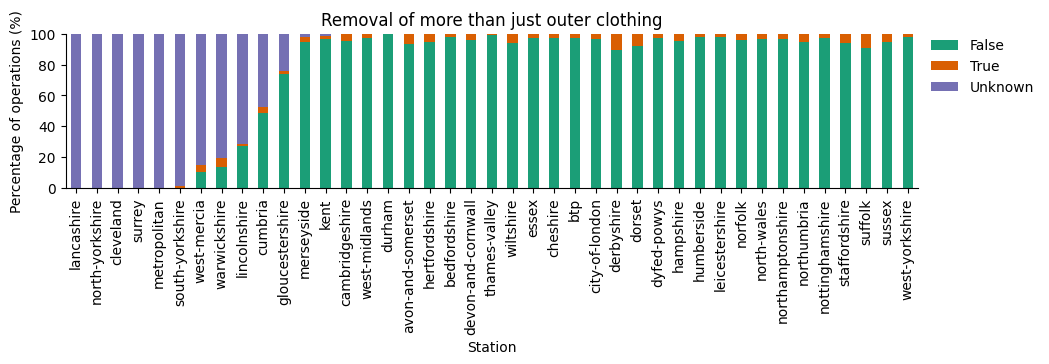

In [57]:
# Sort stations based on count of NaN values in descending order
sorted_stations = grouped_stations_clothing['Unknown'].sort_values(ascending=False).index

# Plot a histogram of the counts for each station
grouped_stations_clothing.loc[sorted_stations].plot(kind='bar', stacked=True, figsize=(11,2), color=palette_tab10)

plt.title('Removal of more than just outer clothing')
plt.xlabel('Station')
plt.ylabel('Percentage of operations (%)')
plt.ylim(0,100)
plt.legend(frameon=False,bbox_to_anchor=(1, 1.05))
sns.despine()

We can se that there are 5 stations that never fill this field: Surrey, North-Yorkshire, Metropolitan, Lancashire and Cleveland.

There are other 4 stations that have more than 70% of missing information: West-Mercia, Warwickshire, South-Yorkshire, Lincolnshire

In [58]:
# stations that have a high percentage of missing information in "removal of clothing" feature
stations_to_exclude = ['surrey', 'north-yorkshire', 'metropolitan', 'lancashire', 'cleveland',
                       'west-mercia', 'warwickshire', 'south-yorkshire', 'lincolnshire']

# create dataframe without the stations chosen above
without_bad_stations = train[~train['station'].isin(stations_to_exclude)]

# evaluate the number of missing information in this field after these stations are removed
without_bad_stations['Removal of more than just outer clothing'].value_counts(dropna=False,normalize=True)*100

False      95.568834
True        3.394460
Unknown     1.036706
Name: Removal of more than just outer clothing, dtype: float64

In [59]:
# Check the gender distribuition of search operations
# where it was necessary to remove more than outer clothing in search opperation
more_clothing = train[train['Removal of more than just outer clothing']==True]
more_clothing['Gender'].value_counts(dropna=False)

Male      10999
Female     1579
Other        20
Name: Gender, dtype: int64

#### POLICE STATION

In [60]:
# Check the station which conducted the search opperation
train['station'].value_counts(dropna=False)

metropolitan          436867
merseyside             38563
thames-valley          31437
west-yorkshire         25321
south-yorkshire        24300
hampshire              20230
btp                    18557
kent                   17875
lancashire             15254
hertfordshire          13971
avon-and-somerset      13189
essex                  12889
sussex                 11378
devon-and-cornwall     10906
surrey                 10774
humberside             10306
west-midlands           9271
west-mercia             9262
staffordshire           9039
norfolk                 8766
leicestershire          8298
cheshire                8271
northumbria             8034
cleveland               7907
nottinghamshire         7523
north-wales             7044
suffolk                 6482
bedfordshire            5904
lincolnshire            5030
dyfed-powys             4851
city-of-london          4539
northamptonshire        4427
warwickshire            3923
durham                  3585
north-yorkshir

In [61]:
# Check the station which conducted the search opperation
train['station'].value_counts(dropna=False, normalize=True)*100

metropolitan          50.999521
merseyside             4.501815
thames-valley          3.669931
west-yorkshire         2.955954
south-yorkshire        2.836764
hampshire              2.361635
btp                    2.166330
kent                   2.086714
lancashire             1.780740
hertfordshire          1.630964
avon-and-somerset      1.539674
essex                  1.504652
sussex                 1.328259
devon-and-cornwall     1.273158
surrey                 1.257749
humberside             1.203115
west-midlands          1.082289
west-mercia            1.081239
staffordshire          1.055206
norfolk                1.023336
leicestershire         0.968702
cheshire               0.965550
northumbria            0.937883
cleveland              0.923057
nottinghamshire        0.878229
north-wales            0.822311
suffolk                0.756704
bedfordshire           0.689228
lincolnshire           0.587198
dyfed-powys            0.566302
city-of-london         0.529879
northamp

In [62]:
train['station'].nunique()

41

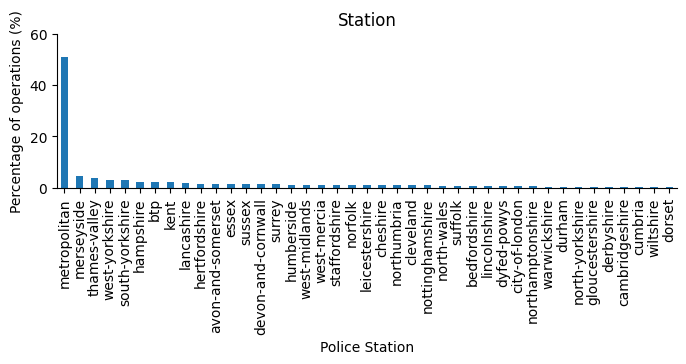

In [63]:
# plot a histogram of all the police stations
plt.figure(figsize=(8,2))
plt.title('Station')
train['station'].value_counts(normalize=True,dropna=False).plot(kind='bar')
plt.xlabel('Police Station')
plt.ylabel('Percentage of operations (%)')
plt.yticks([0,0.2,0.4,0.6],["0","20","40","60"])
sns.despine()

### Feature Engineering

#### Outcome linked to object of search

If there was a search and the outcome has not been written please consider it to be False. We’ve found that officers tend to write the outcomes when they find something, but forget to go back to the application and fill in a None when they don’t find anything. 

In [64]:
# set NaNs to False in "Outcome of search"
train['Outcome linked to object of search'] = train['Outcome linked to object of search'].fillna(False)
train['Outcome linked to object of search'].value_counts(dropna=False)

False    741050
True     115560
Name: Outcome linked to object of search, dtype: int64

#### Create a 'target' feature for our model

The goal for our model (REST API) is to approve or reject a search opperation for the officers in the field. 

Our dataset contains only data from instances where a search was conducted (person or car). We were also given a column with the "Outcome" of the search, which contains information regarding the actions taken by the police following the search operation. After inspection of the "Outcome" column we can see that there were 7 possible outcomes for the search opperations:

- A no further action disposal
- Arrest
- Community resolution
- Penalty Notice for Disorder
- Summons / charged by post
- Khat or Cannabis warning
- Caution (simple or conditional)

Out of all the possible outcomes, only the **"A no further action disposal"** seems to indicate an unjustified search, as all the other outcomes indicate that some violation of the law was comitted, and therefore the search opperation was justified. 

Similarly, we also have a column called 'Outcome linked to object of search' which contains either True or False boolean values depending on whether the outcome of the search was related to the goal of that search. For a search to be successful its outcome also needs to have been linked to it's original goal, therefore the values need to be **True**.

Hence, I will use this information to create a new feature called 'Target', where a search is going to be classified as: with the following criteria:

- **Positive** (True): Outcome is positive (i.e. IS NOT 'A no further action disposal') AND is related to object of search ('Outcome is linked to object of search is True).

- **Negative** (False): Whenever the outcome is negative (is 'A no further action disposal') OR is not related to object of search ('Outcome is linked to object of search is False).

In [65]:
train['Target'] = (train['Outcome linked to object of search'] == True) & (train['Outcome'] != 'A no further action disposal')

In [66]:
train['Target'].value_counts(dropna=False,normalize=True)*100

False    91.78074
True      8.21926
Name: Target, dtype: float64

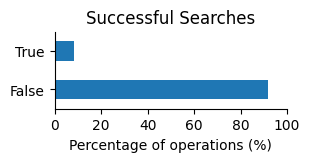

In [67]:
plt.figure(figsize=(3,1))
plt.title('Successful Searches')
plt.xlabel('Percentage of operations (%)')
train['Target'].fillna(False).value_counts(normalize=True,dropna=False).plot(kind='barh',rot=0)
plt.xticks([0,0.2,0.4,0.6,0.8,1],['0','20','40','60','80','100'])
sns.despine()

### BUSINESS QUESTIONS ANALYSIS

In [68]:
# list of stations in the dataset
#list_of_stations = train['station'].unique()
#list_of_stations[:3]

#### Calculate the success rate (in percentage) of searches across police stations

In [69]:
def calculate_successful_search_percentage(data, colname, min_searches):
    
    # list of police stations in dataset
    list_of_stations = train['station'].unique()
    
    # create groupby object with police statio,colname and target (searches)
    grouped = data.groupby(["station", colname, "Target"]).size().unstack()
    
    # create dictionary to store data for each station
    percentage_success_stations = {}
    
    # Print the number of succcessful and not successful searches in each category of colname (per station)
    for station in list_of_stations:  
        station_data = grouped.xs(station, level="station")
        print("Police Station:", station)
        print("Station Data:")
        print(station_data)
        
        # create dictionary to store data for each category
        percentage_success_categories = {}
        
        # Calculate success rate for each unique value in the "colname" column
        unique_categories = station_data.index.unique(level=colname).to_list()
        
        for categorie in unique_categories:
            total_searches = station_data[True][categorie] + station_data[False][categorie]
            if total_searches >= min_searches: # minimum number of searches that categorie needs to have 
                success_rate = station_data[True][categorie] / total_searches
                percentage_success = success_rate * 100
                print('Percentage success ({}) : {}'.format(categorie, percentage_success))
                percentage_success_categories[categorie] = percentage_success
        
        percentage_success_stations[station] = percentage_success_categories
        print('---')
    
    return percentage_success_stations

#### Success Percentage across gender

In [70]:
### gender
success_percentage_gender = calculate_successful_search_percentage(data = train, colname="Gender",min_searches=30)

Police Station: hampshire
Station Data:
Target    False    True
Gender                 
Female   2054.0   697.0
Male    12562.0  4770.0
Other     124.0    23.0
Percentage success (Female) : 25.33624136677572
Percentage success (Male) : 27.52134779598431
Percentage success (Other) : 15.646258503401361
---
Police Station: sussex
Station Data:
Target   False    True
Gender                
Female  1343.0   259.0
Male    7617.0  2159.0
Percentage success (Female) : 16.16729088639201
Percentage success (Male) : 22.08469721767594
---
Police Station: south-yorkshire
Station Data:
Target    False    True
Gender                 
Female   2550.0   142.0
Male    19625.0  1983.0
Percentage success (Female) : 5.274888558692422
Percentage success (Male) : 9.177156608663458
---
Police Station: staffordshire
Station Data:
Target   False    True
Gender                
Female   876.0   178.0
Male    6288.0  1545.0
Other    127.0    25.0
Percentage success (Female) : 16.888045540796963
Percentage success 

#### Success Percentage across Ethinicities

In [71]:
### ethnicity
success_percentage_ethnicity = calculate_successful_search_percentage(data= train,
                                                                      colname="Officer-defined ethnicity",min_searches=30)

Police Station: hampshire
Station Data:
Target                     False  True
Officer-defined ethnicity             
White                      11838  4481
Black                       1622   538
Asian                        814   297
Mixed                          0     0
Other                        466   174
Percentage success (White) : 27.458790367056807
Percentage success (Black) : 24.90740740740741
Percentage success (Asian) : 26.732673267326735
Percentage success (Other) : 27.187499999999996
---
Police Station: sussex
Station Data:
Target                     False  True
Officer-defined ethnicity             
White                       7511  2076
Black                        948   215
Asian                        368    94
Mixed                          0     0
Other                        133    33
Percentage success (White) : 21.654323563158442
Percentage success (Black) : 18.486672398968185
Percentage success (Asian) : 20.346320346320347
Percentage success (Other) : 19.879518

Police Station: dorset
Station Data:
Target                     False  True
Officer-defined ethnicity             
White                       1927   590
Black                        180    67
Asian                         56    17
Mixed                          0     0
Other                         19     1
Percentage success (White) : 23.440603893524038
Percentage success (Black) : 27.125506072874494
Percentage success (Asian) : 23.28767123287671
---
Police Station: suffolk
Station Data:
Target                     False  True
Officer-defined ethnicity             
White                       4396   997
Black                        405    82
Asian                         95    31
Mixed                        258    55
Other                        133    30
Percentage success (White) : 18.486927498609308
Percentage success (Black) : 16.83778234086242
Percentage success (Asian) : 24.6031746031746
Percentage success (Mixed) : 17.57188498402556
Percentage success (Other) : 18.404907975460

#### Success Percentage across Age

In [72]:
# age
success_percentage_age = calculate_successful_search_percentage(data=train, colname="Age range", min_searches=30)

Police Station: hampshire
Station Data:
Target      False    True
Age range                
10-17      3653.0   836.0
18-24      4908.0  2375.0
25-34      3083.0  1304.0
over 34    3088.0   975.0
under 10      8.0     NaN
Percentage success (10-17) : 18.62330140343061
Percentage success (18-24) : 32.61018810929562
Percentage success (25-34) : 29.724185092318212
Percentage success (over 34) : 23.997046517351713
---
Police Station: sussex
Station Data:
Target      False   True
Age range               
10-17      2122.0  412.0
18-24      2716.0  856.0
25-34      2088.0  632.0
over 34    2027.0  516.0
under 10      7.0    2.0
Percentage success (10-17) : 16.25887924230466
Percentage success (18-24) : 23.96416573348264
Percentage success (25-34) : 23.235294117647058
Percentage success (over 34) : 20.290994887927642
---
Police Station: south-yorkshire
Station Data:
Target      False   True
Age range               
10-17      3628.0  211.0
18-24      6762.0  957.0
25-34      5849.0  551.0
ove

### Identify problematic stations

In [73]:
no_data_stations = ['humberside','lancashire','metropolitan']

### identify discriminatory stations
def find_problematic_stations(data, threshold):
    problematic_stations = {}
    for station, percentages in data.items():
        if station not in no_data_stations:
            max_percentage = max(percentages.values())
            min_percentage = min(percentages.values())
            if max_percentage - min_percentage >= threshold:
                problematic_stations[station] = percentages
    return problematic_stations

In [74]:
### problematic stations in regards to gender (using treshold of 10% difference in successfull search)
problematic_gender = find_problematic_stations(data=success_percentage_gender, threshold=10)
problematic_gender

{'hampshire': {'Female': 25.33624136677572,
  'Male': 27.52134779598431,
  'Other': 15.646258503401361}}

In [75]:
### problematic stations in regards to ethnicity (using treshold of 10% difference in successfull search)
problematic_ethinicity = find_problematic_stations(data=success_percentage_ethnicity, threshold=10)
problematic_ethinicity

{'staffordshire': {'White': 19.12829621532996,
  'Black': 20.208023774145616,
  'Asian': 20.634920634920633,
  'Other': 10.256410256410255},
 'cambridgeshire': {'White': 23.05863708399366,
  'Black': 25.53191489361702,
  'Asian': 28.205128205128204,
  'Other': 16.470588235294116},
 'north-wales': {'White': 17.50625782227785,
  'Black': 14.666666666666666,
  'Asian': 33.33333333333333,
  'Other': 14.312267657992564},
 'gloucestershire': {'White': 19.808087731322825,
  'Black': 20.51282051282051,
  'Asian': 25.31645569620253,
  'Other': 15.167095115681233}}

In [76]:
### problematic stations in regards to age (using treshold of 10% difference in successfull search)
problematic_age = find_problematic_stations(data=success_percentage_age, threshold=10)
problematic_age

{'hampshire': {'10-17': 18.62330140343061,
  '18-24': 32.61018810929562,
  '25-34': 29.724185092318212,
  'over 34': 23.997046517351713},
 'staffordshire': {'10-17': 12.805872756933114,
  '18-24': 24.920802534318902,
  '25-34': 19.27710843373494,
  'over 34': 16.294555424990207},
 'bedfordshire': {'10-17': 18.1653042688465,
  '18-24': 27.120938628158846,
  '25-34': 20.94048493754592,
  'over 34': 14.063777596075225},
 'nottinghamshire': {'10-17': 9.62671905697446,
  '18-24': 26.854537919602155,
  '25-34': 25.995085995085994,
  'over 34': 23.46588119783996},
 'devon-and-cornwall': {'10-17': 11.31367292225201,
  '18-24': 22.991071428571427,
  '25-34': 19.379285456513895,
  'over 34': 16.682769726247987},
 'northamptonshire': {'10-17': 15.121255349500714,
  '18-24': 25.272727272727273,
  '25-34': 24.638989169675092,
  'over 34': 17.25206611570248},
 'wiltshire': {'10-17': 11.446740858505565,
  '18-24': 23.26530612244898,
  '25-34': 20.348837209302324,
  'over 34': 15.789473684210526},
 'c

### Create histograms to show problematic stations

In [77]:
def create_police_station_histogram(data,figsize,rotation):
    police_stations = list(data.keys())
    genders = categories
    width = 0.1
    
    plt.figure(figsize=figsize)
    
    for i, gender in enumerate(genders):
        percentages = [data[station].get(gender, 0) for station in police_stations]
        plt.bar([j + i * width for j in range(len(police_stations))], percentages, width=width, label=gender)
    
    plt.xlabel('Station')
    plt.ylabel('Successful\nsearches (%)')
    plt.xticks([i + width for i in range(len(police_stations))], police_stations, rotation=rotation)
    plt.yticks([0,20,40])
    plt.legend(frameon=False,bbox_to_anchor=(1, 1.05))
    
    sns.despine()

#### Problematic Stations (Gender)

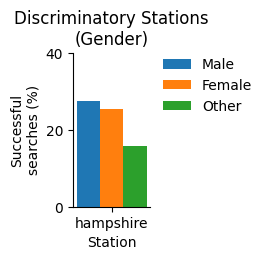

In [78]:
categories = train['Gender'].unique()
create_police_station_histogram(data=problematic_gender,figsize=(1,2),rotation=0)
plt.title('Discriminatory Stations\n(Gender)');

#### Problematic Stations (Ethinicity)

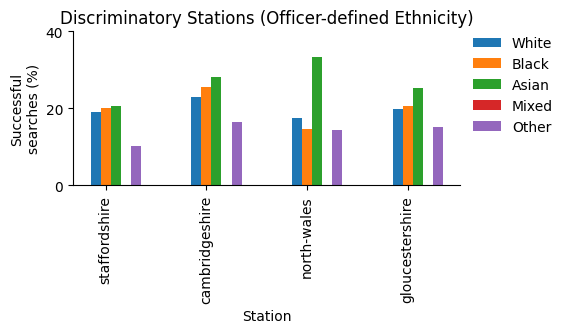

In [79]:
categories = ['White','Black','Asian','Mixed','Other']
create_police_station_histogram(data=problematic_ethinicity,figsize=(5,2),rotation=90)
plt.title('Discriminatory Stations (Officer-defined Ethnicity)');

#### Problematic Stations (Age)

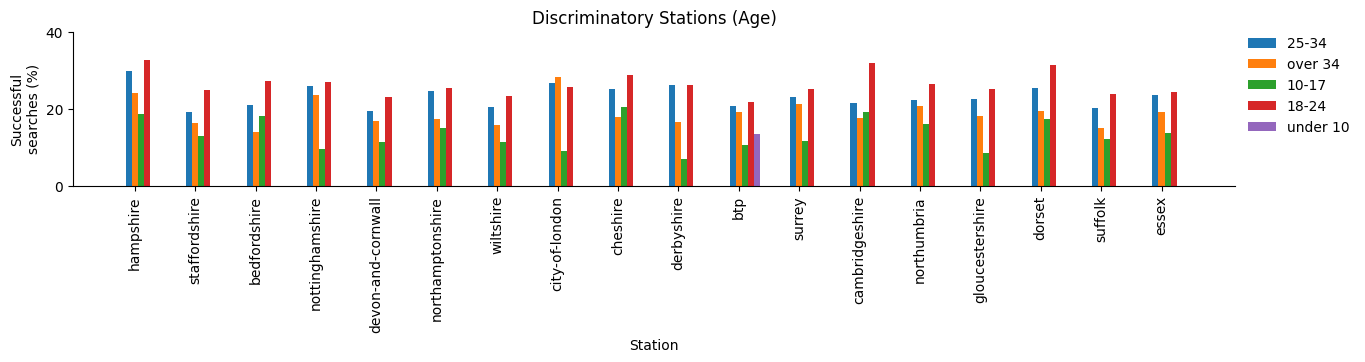

In [80]:
categories = train['Age range'].unique()
create_police_station_histogram(data=problematic_age, figsize=(15,2), rotation=90)
plt.title('Discriminatory Stations (Age)');

#### EXTRA ANALYSIS: USING BROAD DEFINITION OF SELF-DEFINED ETHNICITY

In [81]:
success_percentage_ethnicity_self = calculate_successful_search_percentage(data=train, colname="Self-defined ethnicity_broad",min_searches=30)

Police Station: hampshire
Station Data:
Target                          False    True
Self-defined ethnicity_broad                 
Asian                           511.0   217.0
Black                           946.0   349.0
Mixed                           482.0   204.0
Other                          2228.0   562.0
White                         10573.0  4158.0
Percentage success (Asian) : 29.807692307692307
Percentage success (Black) : 26.94980694980695
Percentage success (Mixed) : 29.737609329446062
Percentage success (Other) : 20.14336917562724
Percentage success (White) : 28.226189668046974
---
Police Station: sussex
Station Data:
Target                         False    True
Self-defined ethnicity_broad                
Asian                          282.0    72.0
Black                          684.0   168.0
Mixed                          182.0    60.0
Other                          789.0   184.0
Unknown                        188.0    45.0
White                         6835.0  1889.0

In [82]:
problematic_ethinicity_self = find_problematic_stations(data=success_percentage_ethnicity_self, threshold=10)
problematic_ethinicity_self

{'bedfordshire': {'Asian': 24.689440993788818,
  'Black': 21.664050235478808,
  'Mixed': 26.785714285714285,
  'Other': 16.25124626121635,
  'White': 21.110299488677867},
 'cumbria': {'Asian': 30.64516129032258,
  'Black': 32.25806451612903,
  'Other': 17.934782608695652,
  'White': 21.23438648052902},
 'nottinghamshire': {'Asian': 22.587268993839835,
  'Black': 25.412541254125415,
  'Mixed': 23.67601246105919,
  'Other': 15.432098765432098,
  'White': 25.996881265315213},
 'warwickshire': {'Asian': 28.013029315960914,
  'Black': 29.39189189189189,
  'Mixed': 19.17808219178082,
  'Other': 19.189765458422176,
  'Unknown': 30.23255813953488,
  'White': 25.445765230312034},
 'devon-and-cornwall': {'Asian': 16.091954022988507,
  'Black': 21.19815668202765,
  'Mixed': 23.931623931623932,
  'Other': 9.67741935483871,
  'Unknown': 17.962371317003907,
  'White': 18.26633494827812},
 'durham': {'Asian': 39.473684210526315,
  'Other': 15.09433962264151,
  'White': 27.802294792586054},
 'norfolk'

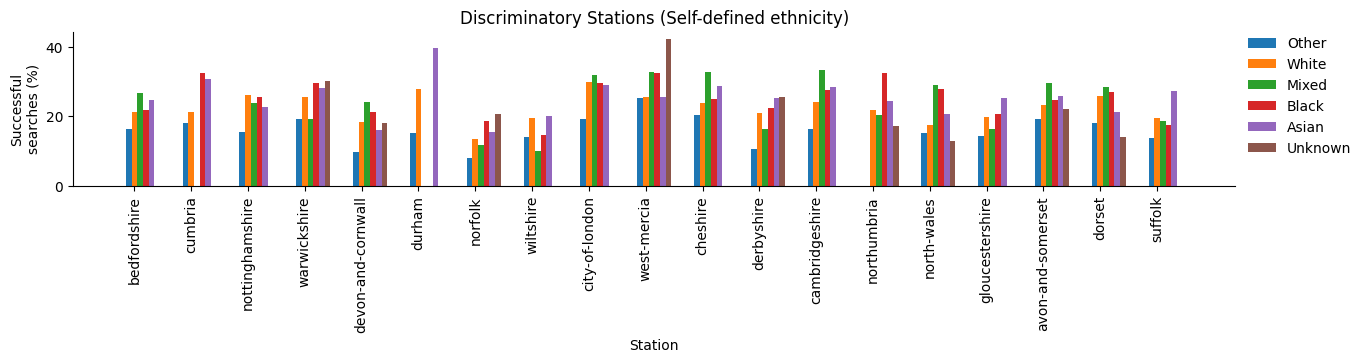

In [83]:
categories = train['Self-defined ethnicity_broad'].unique()
create_police_station_histogram(data=problematic_ethinicity_self, figsize=(15,2), rotation=90)
plt.title('Discriminatory Stations (Self-defined ethnicity)');

### Removal of clothing Discrimination

In [84]:
# stations that have a high percentage of missing information in "removal of clothing" feature
stations_to_exclude = ['surrey', 'north-yorkshire', 'metropolitan', 'lancashire', 'cleveland',
                       'west-mercia', 'warwickshire', 'south-yorkshire', 'lincolnshire']

# create dataframe without the stations chosen above
without_bad_stations = train[~train['station'].isin(stations_to_exclude)]

# evaluate the number of missing information in this field after these stations are removed
without_bad_stations['Removal of more than just outer clothing'].value_counts(dropna=False,normalize=True)*100

False      95.568834
True        3.394460
Unknown     1.036706
Name: Removal of more than just outer clothing, dtype: float64

#### Are women more likely to be asked to remove clothing (than man or other)?

In [85]:
def calculate_removal_clothing_percentage(data, colname, min_searches):
    
    # list of police stations in dataset who don't have a lot of missing values in "clothing" feature
    list_of_stations = without_bad_stations['station'].unique()
    
    # create groupby object with police statio,colname and target (searches)
    grouped = data.groupby(["station", colname, "Removal of more than just outer clothing"]).size().unstack()
    
    # create dictionary to store data for each station
    percentage_success_stations = {}
    
    # Print the number of succcessful and not successful searches in each category of colname (per station)
    for station in list_of_stations:  
        station_data = grouped.xs(station, level="station")
        print("Police Station:", station)
        print("Station Data:")
        print(station_data)
        
        # create dictionary to store data for each category
        percentage_success_categories = {}
        
        # Calculate success rate for each unique value in the "colname" column
        unique_categories = station_data.index.unique(level=colname).to_list()
        
        for categorie in unique_categories:
            total_searches = station_data[True][categorie] + station_data[False][categorie]
            if total_searches >= min_searches: # minimum number of searches that categorie needs to have 
                success_rate = station_data[True][categorie] / total_searches
                percentage_success = success_rate * 100
                print('Percentage asked to remove ({}) : {}'.format(categorie, percentage_success))
                percentage_success_categories[categorie] = percentage_success
        
        percentage_success_stations[station] = percentage_success_categories
        print('---')
    
    return percentage_success_stations

In [86]:
clothing_removal_genders = calculate_removal_clothing_percentage(data=train, colname="Gender", min_searches=30);

Police Station: hampshire
Station Data:
Removal of more than just outer clothing    False   True  Unknown
Gender                                                           
Female                                     2616.0  135.0      NaN
Male                                      16518.0  814.0      NaN
Other                                       142.0    5.0      NaN
Percentage asked to remove (Female) : 4.907306434023991
Percentage asked to remove (Male) : 4.696515116547427
Percentage asked to remove (Other) : 3.4013605442176873
---
Police Station: sussex
Station Data:
Removal of more than just outer clothing   False   True  Unknown
Gender                                                          
Female                                    1516.0   86.0      NaN
Male                                      9265.0  511.0      NaN
Percentage asked to remove (Female) : 5.368289637952559
Percentage asked to remove (Male) : 5.22708674304419
---
Police Station: staffordshire
Station Data:
Remova

In [87]:
list_of_stations = without_bad_stations['station'].unique()

### identify discriminatory stations
def find_problematic_stations(data, threshold):
    problematic_stations = {}
    for station, percentages in data.items():
        if station in list_of_stations:
            max_percentage = max(percentages.values())
            min_percentage = min(percentages.values())
            if max_percentage - min_percentage >= threshold:
                problematic_stations[station] = percentages
    return problematic_stations

In [88]:
problematic_clothing_gender = find_problematic_stations(data=clothing_removal_genders, threshold=10)
problematic_clothing_gender

{}

In [89]:
problematic_clothing_gender = find_problematic_stations(data=clothing_removal_genders, threshold=5)
problematic_clothing_gender

{'cumbria': {'Female': 13.147410358565736, 'Male': 6.221889055472264}}

#### Are women of certain age groups asked to remove clothing more often than women of other age groups?

In [90]:
only_female = train[train['Gender']=='Female']

In [91]:
clothing_removal_genders_ages = calculate_removal_clothing_percentage(data=only_female, colname="Age range", min_searches=30);

Police Station: hampshire
Station Data:
Removal of more than just outer clothing  False  True  Unknown
Age range                                                     
10-17                                     477.0   2.0      NaN
18-24                                     896.0  35.0      NaN
25-34                                     599.0  43.0      NaN
over 34                                   643.0  55.0      NaN
under 10                                    1.0   NaN      NaN
Percentage asked to remove (10-17) : 0.41753653444676403
Percentage asked to remove (18-24) : 3.7593984962406015
Percentage asked to remove (25-34) : 6.697819314641744
Percentage asked to remove (over 34) : 7.8796561604584525
---
Police Station: sussex
Station Data:
Removal of more than just outer clothing  False  True  Unknown
Age range                                                     
10-17                                     341.0   4.0      NaN
18-24                                     437.0  21.0      NaN


In [92]:
problematic_clothing_gender_age = find_problematic_stations(data=clothing_removal_genders_ages, threshold=10)
problematic_clothing_gender_age

{'cumbria': {'10-17': 3.0303030303030303,
  '18-24': 10.526315789473683,
  '25-34': 17.72151898734177,
  'over 34': 15.0},
 'derbyshire': {'18-24': 2.7522935779816518,
  '25-34': 20.792079207920793,
  'over 34': 16.483516483516482},
 'cambridgeshire': {'10-17': 1.2048192771084338,
  '18-24': 4.0,
  '25-34': 13.157894736842104,
  'over 34': 7.246376811594203}}

In [93]:
problematic_clothing_gender_age = find_problematic_stations(data=clothing_removal_genders_ages, threshold=5)
problematic_clothing_gender_age

{'hampshire': {'10-17': 0.41753653444676403,
  '18-24': 3.7593984962406015,
  '25-34': 6.697819314641744,
  'over 34': 7.8796561604584525},
 'sussex': {'10-17': 1.1594202898550725,
  '18-24': 4.585152838427948,
  '25-34': 7.960199004975125,
  'over 34': 7.341772151898734},
 'staffordshire': {'10-17': 0.8264462809917356,
  '18-24': 7.4074074074074066,
  '25-34': 8.96551724137931,
  'over 34': 8.092485549132949},
 'cumbria': {'10-17': 3.0303030303030303,
  '18-24': 10.526315789473683,
  '25-34': 17.72151898734177,
  'over 34': 15.0},
 'devon-and-cornwall': {'10-17': 2.479338842975207,
  '18-24': 1.735357917570499,
  '25-34': 4.761904761904762,
  'over 34': 8.076923076923077},
 'norfolk': {'10-17': 1.1173184357541899,
  '18-24': 2.7700831024930745,
  '25-34': 3.216374269005848,
  'over 34': 7.512953367875648},
 'wiltshire': {'18-24': 1.6666666666666667,
  '25-34': 6.666666666666667,
  'over 34': 8.16326530612245},
 'derbyshire': {'18-24': 2.7522935779816518,
  '25-34': 20.792079207920793,

#### EXTRA ANALYSIS: Look at the percentages of male searches (with removal of more than outer clothing) across age-groups

In [94]:
only_male = train[train['Gender']=='Male']
clothing_removal_genders_ages_male = calculate_removal_clothing_percentage(data=only_male, colname="Age range", min_searches=30);

Police Station: hampshire
Station Data:
Removal of more than just outer clothing   False   True  Unknown
Age range                                                       
10-17                                     3875.0   92.0      NaN
18-24                                     5920.0  371.0      NaN
25-34                                     3543.0  187.0      NaN
over 34                                   3173.0  164.0      NaN
under 10                                     7.0    NaN      NaN
Percentage asked to remove (10-17) : 2.3191328459793294
Percentage asked to remove (18-24) : 5.897313622635511
Percentage asked to remove (25-34) : 5.013404825737265
Percentage asked to remove (over 34) : 4.914593946658676
---
Police Station: sussex
Station Data:
Removal of more than just outer clothing   False   True  Unknown
Age range                                                       
10-17                                     2144.0   45.0      NaN
18-24                                     2915

In [95]:
problematic_clothing_gender_age_male = find_problematic_stations(data=clothing_removal_genders_ages_male, threshold=10)
problematic_clothing_gender_age_male

{'derbyshire': {'10-17': 1.8547140649149922,
  '18-24': 10.827374872318693,
  '25-34': 15.089163237311384,
  'over 34': 12.867132867132867}}

#### Plot problematic stations in terms of clothing removal

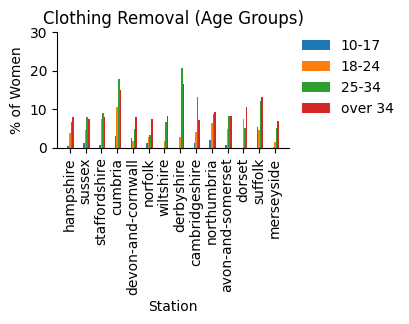

In [96]:
categories = ['10-17','18-24','25-34','over 34']
create_police_station_histogram(data=problematic_clothing_gender_age,figsize=(3,1.5),rotation=90)
plt.title('Clothing Removal (Age Groups)')
plt.ylim(0,30)
plt.yticks([0,10,20,30])
plt.ylabel('% of Women');

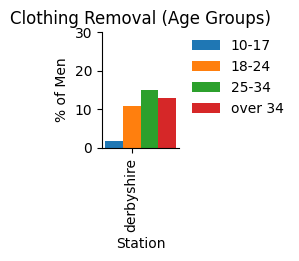

In [97]:
categories = ['10-17','18-24','25-34','over 34']
create_police_station_histogram(data=problematic_clothing_gender_age_male,figsize=(1,1.5),rotation=90)
plt.title('Clothing Removal (Age Groups)')
plt.ylim(0,30)
plt.yticks([0,10,20,30])
plt.ylabel('% of Men');

#### Calculate success rate per station (independently of gender, age or ethnicity)

This can be useful in the discussion to talk about police stations with very low success rates (there should be a minimum of searches per station for it to be admissable)

In [98]:
def calculate_percentage_successful_searches_per_station(data):
    list_of_stations = data['station'].unique()
    
    #dictionary to store percentage of sucessful searches
    percentage_station = {}
    for station in list_of_stations:
        station_data = data[data['station'] == station]
        successful = station_data[station_data['Target'] == True]
        total_searches = station_data.shape[0]
        if total_searches > 0:
            success_percentage = 100 * successful.shape[0] / total_searches
        else:
            success_percentage = 0
        print('% of successful searches ({}) : {:.2f}%'.format(station, success_percentage))
        
        percentage_station[station] = success_percentage
    
    return percentage_station

In [99]:
successful_searches_stations = calculate_percentage_successful_searches_per_station(data=train);

% of successful searches (hampshire) : 27.14%
% of successful searches (sussex) : 21.25%
% of successful searches (south-yorkshire) : 8.74%
% of successful searches (staffordshire) : 19.34%
% of successful searches (bedfordshire) : 21.31%
% of successful searches (cumbria) : 21.28%
% of successful searches (nottinghamshire) : 23.36%
% of successful searches (warwickshire) : 25.18%
% of successful searches (devon-and-cornwall) : 18.27%
% of successful searches (leicestershire) : 0.06%
% of successful searches (durham) : 27.53%
% of successful searches (humberside) : 0.00%
% of successful searches (thames-valley) : 17.98%
% of successful searches (norfolk) : 13.03%
% of successful searches (lincolnshire) : 5.03%
% of successful searches (northamptonshire) : 21.75%
% of successful searches (kent) : 19.60%
% of successful searches (wiltshire) : 18.49%
% of successful searches (city-of-london) : 25.20%
% of successful searches (west-mercia) : 26.05%
% of successful searches (lancashire) : 0

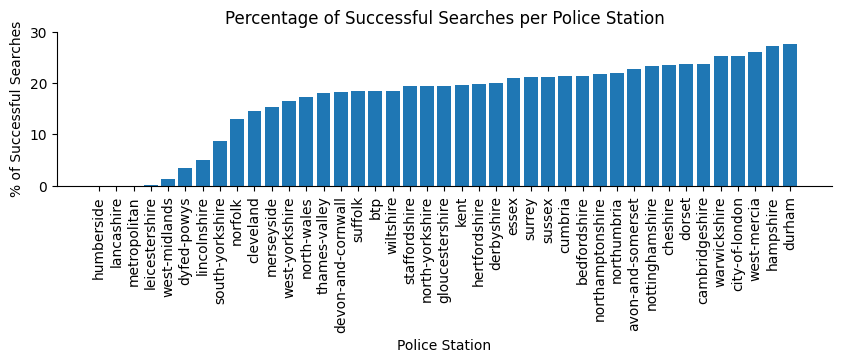

In [100]:
# Plot the percentage of successful searches across police stations
sorted_dict = dict(sorted(successful_searches_stations.items(), key=lambda x: x[1]))

plt.figure(figsize=(10,2))
plt.title('Percentage of Successful Searches per Police Station')
plt.xlabel('Police Station')
plt.ylabel('% of Successful Searches')
plt.bar(sorted_dict.keys(), sorted_dict.values())
plt.yticks([0,10,20,30])
plt.xticks(rotation=90)
sns.despine()
plt.show()